In [170]:
import cv2
import numpy as np
import json
import matplotlib.pyplot as plt
import math

In [171]:
def transform(D_block,method):
    match method:
        case 0:
            # 無轉換
            return D_block
        case 1:
            # 左右翻轉
            return np.fliplr(D_block)
        case 2:
            # 上下翻轉
            return np.flipud(D_block)
        case 3:
            # 主對角對稱
            return D_block.T
        case 4:
            # 次對角對稱
            return np.flip(D_block.T)
        case 5:
            # 旋轉90度
            return np.rot90(D_block,1)
        case 6:
            # 旋轉180度
            return np.rot90(D_block,2)
        case 7:
            # 旋轉270度
            return np.rot90(D_block,3)
        case _:
            return D_block

In [172]:
# 解壓
def deCompress(img,data):
    # 讀取原圖大小以及壓縮資訊
    h,w,rangeSize,domainSize,stepSize=data[0]
    data=data[1:]

    # 將圖片按照壓縮過程分割成同樣位置的Domain Block
    Odomain_Blocks=np.empty(((img.shape[0]-domainSize)//stepSize+1,(img.shape[1]-domainSize)//stepSize+1,domainSize,domainSize),np.uint8)
    for row in range(Odomain_Blocks.shape[0]):
        for col in range(Odomain_Blocks.shape[1]):
            Odomain_Blocks[row,col]=img[row*stepSize:row*stepSize+domainSize,col*stepSize:col*stepSize+domainSize].copy()

    # Domain Block均值收縮成Range Block大小
    OdomainContraction_Blocks=np.empty((Odomain_Blocks.shape[0],Odomain_Blocks.shape[1],rangeSize,rangeSize),np.uint8)
    for row in range(Odomain_Blocks.shape[0]):
        for col in range(Odomain_Blocks.shape[1]):
            OdomainContraction_Blocks[row,col]=cv2.resize(Odomain_Blocks[row,col],(rangeSize,rangeSize))

    # 將min_block每個元素還原回Range Block
    output=img.copy()
    for row in range(len(data)):
        for col in range(len(data[row])):
            # 將D根據壓縮的轉換方法轉換
            D_block=transform(OdomainContraction_Blocks[data[row][col][0]][data[row][col][1]],data[row][col][2])
            # 按照轉換公式 D*s+o = R 算出新的R
            D_block=D_block*(data[row][col][3])+data[row][col][4]
            # 大於255的值設為255
            D_block=np.clip(D_block,0,255)
            # 把計算結果當成新的R塊
            output[row*rangeSize:((row+1)*rangeSize),col*rangeSize:(col+1)*rangeSize]=D_block
    # 將所有新的R塊結合在一起，就是一次迭代後輸出的圖
    return output

In [173]:
def show_output(imgs):
    plt.figure()
    nb_row = math.ceil(np.sqrt(len(imgs)))
    nb_cols = nb_row
    # Plot
    for i, img in enumerate(imgs):
        plt.subplot(nb_row, nb_cols, i+1)
        plt.imshow(img, cmap='gray', vmin=0, vmax=255, interpolation='none')
        plt.title(str(i))
        frame = plt.gca()
        frame.axes.get_xaxis().set_visible(False)
        frame.axes.get_yaxis().set_visible(False)
    plt.tight_layout()

In [174]:
# 讀取壓縮檔，並生成一個與原圖大小相同的隨機圖片
def setting(file,read_bin):
    if read_bin:
        file="output/"+file+".bin"
        with open(file , 'rb') as f:
            bin_data = f.read()

        # 讀取圖片 高 , 寬 , rangeSize , domainSize , stepSize
        data=[[]]
        for i in range(5):
            data[0].append(bin_data[i])
        bin_data=bin_data[5:]

        # 讀取  D索引(2維) , 轉換方法(0~7)  , s(0,0.25,0.5,0.75,1) , o(0~128)
        count=0
        col = data[0][1]//data[0][2]
        for i in bin_data:
            if count==0:
                temp=[]
            if count%5==0:
                temp_=[]
            temp_.append(i)
            count+=1
            if count%5==0:
                temp.append(temp_)
            if count >= col*5:
                data.append(temp)
                count=0
    else:
        file="output/"+file+".json"
        with open(file , 'r') as file:
            data = json.load(file)


    # 與原圖大小相同的隨機圖片
    return (data,[np.random.randint(0,256,(data[0][0],data[0][1]))])

In [175]:
file="house"
data, output = setting(file,False)

In [176]:
# 進行10次迭代的解壓縮
for i in range(10):
    output.append(deCompress(output[-1],data))

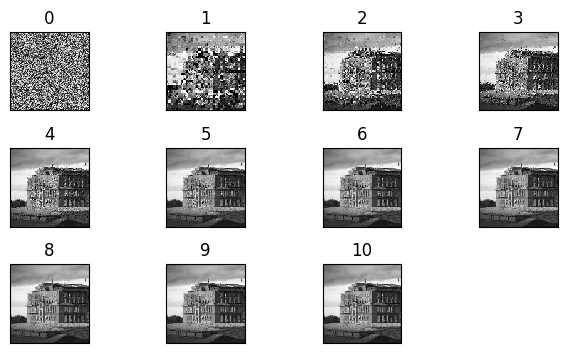

In [177]:
show_output(output[-11:])

In [154]:
cv2.imwrite("output/"+file+".jpg" ,output[-1])

True